<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загружаем требуемые библиотеки

In [1]:
#common
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from statsmodels.tsa.seasonal import seasonal_decompose

# ML
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV





Загружаем данные

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Исходный датасет содержит 26496 наблюдений, временной интревал наблюдений составляет 10 минут.
Пропущенных значений нет.
При первичном анализе установлено, что временной промежуток данных длится с 1 марта 2018 года по 31 августа 2018 года. 

Проверим монотонность даты (индекса).

In [5]:
if taxi.index.is_monotonic == True :
    print('Даты расположены в хронологическом порядке')
else:
    print('Требуется предобработка')

Даты расположены в хронологическом порядке


Проблем с датами пока не обнаружено.

Ресемплируем данные по 1 часу.

In [6]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
taxi.sort_values(by='num_orders')

,num_orders
datetime,
2018-04-06 06:00:00,0
2018-04-05 06:00:00,1
2018-03-09 05:00:00,1
2018-04-03 06:00:00,1
2018-04-24 06:00:00,2
...,...
2018-08-27 04:00:00,295
2018-08-30 17:00:00,342
2018-08-27 02:00:00,408


**Вывод**

На данном этапе были загружены данные и требуемые библиотеки.
Первичный анализ временных рядов не выявил аномалий и пропущенных значений. Данные о числе заказов также не содержат пропусков.

## Анализ

Посмотрим на распределение заказов.

In [9]:
taxi.sort_values(by='num_orders')

,num_orders
datetime,
2018-04-06 06:00:00,0
2018-04-05 06:00:00,1
2018-03-09 05:00:00,1
2018-04-03 06:00:00,1
2018-04-24 06:00:00,2
...,...
2018-08-27 04:00:00,295
2018-08-30 17:00:00,342
2018-08-27 02:00:00,408


462 заказа в 2 часа ночи 20 августа понедельник - люди возвращаются домой после выходных, отпусков. И полное отсутсвие в 6 утра 6 апреля пятница - никому никуда не нужно. Отрицательных и сверх-огромных значений не замечено.

Построим диаграмму распределения

Медианное значение заказов =  78.0


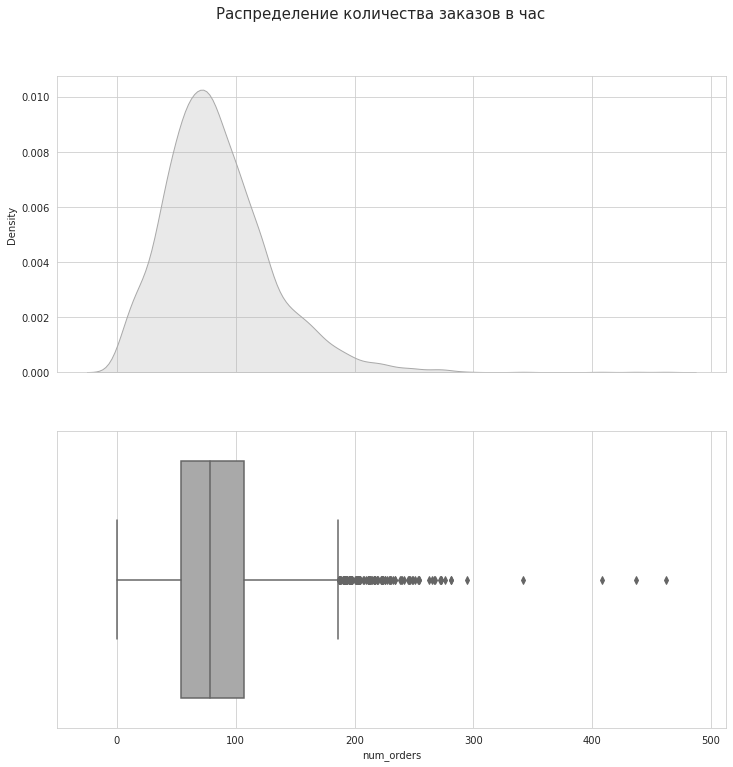

In [10]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2,1,sharex=True, figsize=(12,12))

sns.kdeplot(taxi['num_orders'], color='darkgrey', shade=True, label='Количество заказов', ax=axes[0])
sns.boxplot(taxi['num_orders'], orient='h', color='darkgrey')

plt.suptitle('Распределениe количества заказов в час', size=15, y=(0.96));

print('Медианное значение заказов = ', taxi['num_orders'].median())

Чаще всего в час заказов поступает в районе 78 заказов.

Проверим, к какому типу принадлежит наш временной ряд.

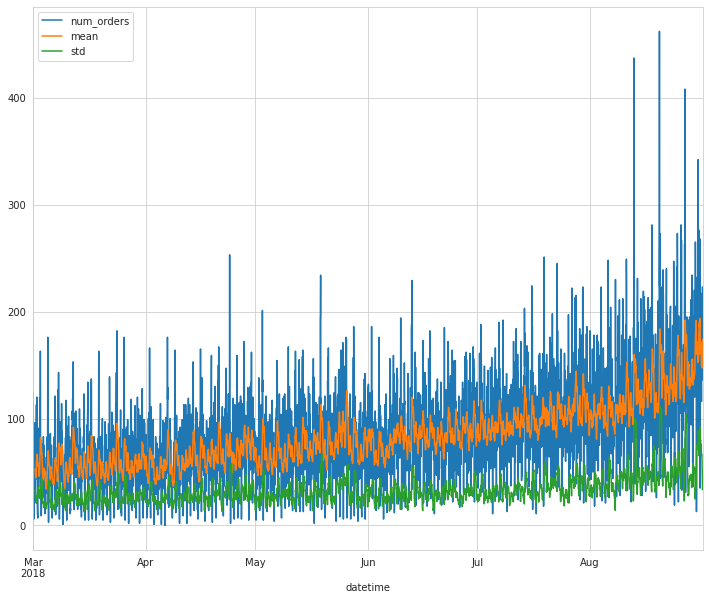

In [11]:
taxi['mean'] = taxi['num_orders'].rolling(15).mean()
taxi['std'] = taxi['num_orders'].rolling(15).std()

taxi.plot(figsize=(12,10));

Скользящее среднее отклонение со временем изменяеся не слишком сильно. При этом среднее значение - достаточно высоко поднимется в августе. Из этого следует, что перед нами - нестационарный временной ряд.

Проанализируем тренд и сезонность.

In [12]:
taxi = taxi.drop(['mean','std'], axis=1)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

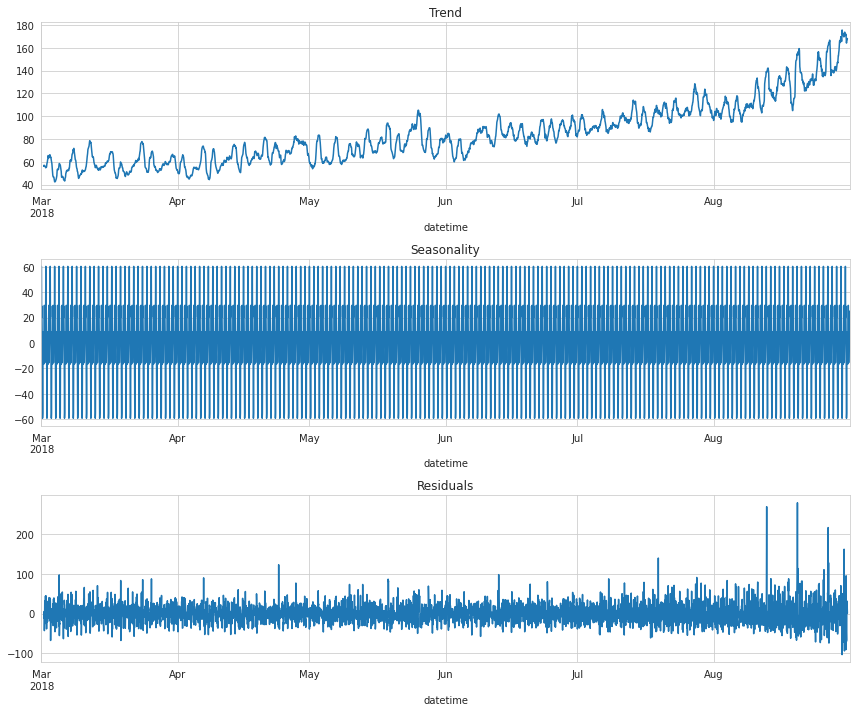

In [13]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На данном графике заметен глобальный тренд увеличения числа заказов такси на протяжении всего изучаемого периода.
Колебяния сезонности на данном графике изучить невозможно, увеличим масштаб.
Посмотрим на два разных месяца - апрель и август и первые трое суток.

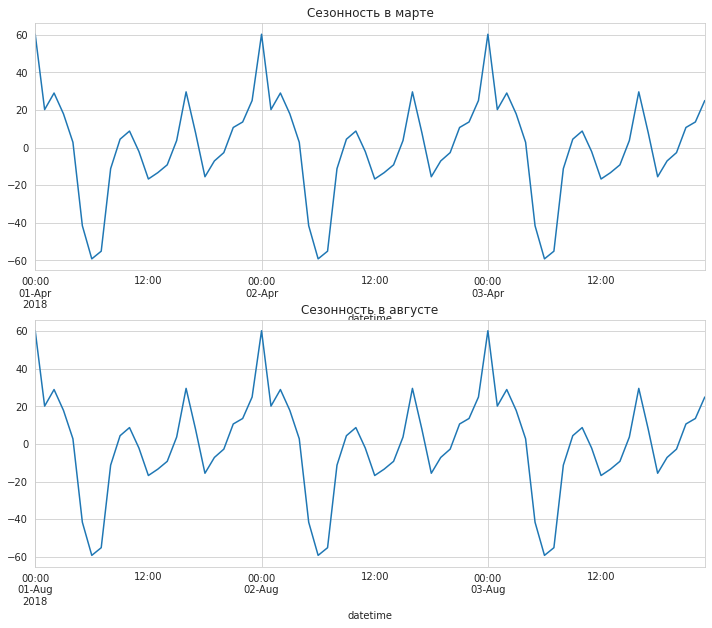

In [14]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
decomposed.seasonal['2018-04-01':'2018-04-03'].plot(ax=plt.gca())
plt.title('Сезонность в марте')
plt.subplot(212)
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.title('Сезонность в августе');

Больше всего заказов такси приходится на 00 часов. Приближается время прекращения движения общественного транспорта.
Минимальное количество заказов в районе 6-7 часов утра - начало движения общественного транспорта. 
Так же заметен второй по величине пик заказов в районе 16-17 дня - связано, по всей видимости с окончанием рабочего дня.

**Выводы**

На данном этапе был произведен анализ исходных данных. За время исследования обнаружены следующие особенности:

1. Чаще всего за час в службу такси поступают 78 заказов.
2. На протяжении всего года заметен тренд к увеличению количество заказов.
3. Обнаружена "сезонность" загруженности: пиковые часы приходятся на 00 и 16-17 часов вечера,
4. Минимальная загрузка наблюдается в течение часа, с 6 до 7 утра, так же две небольшие просадки количества заказов заметны в 12 и 18 часов.

Перейдём к более точному прогнозированию и обучению моделей.

## Обучение

**feature engeneering**

Создадим дополнительные признаки в исходном сете для лучшего обучения моделей.

На вход функция принимает датасет, количество "шагов" для отстающий значений и скользящее среднее без учета текущего значения количества заказов.
Новые признаки так же определяются, как месяц, день, день недели и час.

In [15]:
def new_features(data, max_lag, rolling_mean_size):
    
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
new_features(taxi,24,10)

In [17]:
taxi.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Остаются пропущенные значения, но их не так много и они будут удалены после разбития на выборки.

**Создание подвыборок**

Разобьем датасет на обучающую, валидационную и тестовую выборку.

In [18]:
sub, test = train_test_split(taxi, test_size=.1, shuffle=False)
train, valid = train_test_split(sub, test_size=.1, shuffle=False)

In [19]:
train.dropna(inplace=True)

In [20]:
train.shape[0], valid.shape[0], test.shape[0]

(3552, 398, 442)

Разбиваем фичи на признаки и целевой признак

In [21]:
X_train = train.drop(['num_orders'], axis=1)
X_valid = valid.drop(['num_orders'], axis=1)
X_test = test.drop(['num_orders'], axis=1)

y_train = train['num_orders']
y_valid = valid['num_orders']
y_test = test['num_orders']


**Проверка моделей на адекватность**

In [22]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3552 entries, 2018-03-02 00:00:00 to 2018-07-27 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   day           3552 non-null   int64  
 1   dayofweek     3552 non-null   int64  
 2   hour          3552 non-null   int64  
 3   lag_1         3552 non-null   float64
 4   lag_2         3552 non-null   float64
 5   lag_3         3552 non-null   float64
 6   lag_4         3552 non-null   float64
 7   lag_5         3552 non-null   float64
 8   lag_6         3552 non-null   float64
 9   lag_7         3552 non-null   float64
 10  lag_8         3552 non-null   float64
 11  lag_9         3552 non-null   float64
 12  lag_10        3552 non-null   float64
 13  lag_11        3552 non-null   float64
 14  lag_12        3552 non-null   float64
 15  lag_13        3552 non-null   float64
 16  lag_14        3552 non-null   float64
 17  lag_15        3552 non-null

Проверили на соответствие следования по времени обучающей и тестовой выборок. Обучающая выборка предваряет тестовую.

Попробуем предсказать временной период медианный значеним и посмотрим, какого качества метрики rmse мы сможем добиться.
(далее все модели в данном разделе будем тестировать только на валидационной выборке)

In [23]:
y_valid_med = np.ones(y_valid.shape) * y_train.median()
y_test_med = np.ones(y_test.shape) * y_train.median()

print("RMSE valid:", mean_squared_error(y_valid, y_valid_med)**0.5)
print("RMSE test:", mean_squared_error(y_test, y_test_med)**0.5)

RMSE valid: 59.533361281953816
RMSE test: 88.64441651443998


Отклоняемся на 89 заказов на тестовой выборке. Не самый радужный результат.

**Подбор и тестирование моделей**

Применяем логистическую регрессию

In [24]:
%%time
lr = LinearRegression().fit(X_train, y_train)

CPU times: user 4.52 ms, sys: 8.84 ms, total: 13.4 ms
Wall time: 5.42 ms


In [25]:
def prediction(model, feat, targ):
    
    pred = model.predict(feat)
    rmse = mean_squared_error(pred, targ)**0.5
    
    return(rmse)

In [26]:
%%time

prediction(lr, X_valid, y_valid)

CPU times: user 7.62 ms, sys: 778 µs, total: 8.4 ms
Wall time: 2.92 ms


34.39818972247567

Создадим табличку, в которую будем вносить полученые данные

In [71]:
res = {
    'model_name':pd.Series(['dummy','LogReg','GradBoost','CatBoost']),
    'training_time':pd.Series([]),
    'prediction_valid_time':pd.Series([]), 
    'rmse_valid':pd.Series([])}
 

results = pd.DataFrame(res)
results

,model_name,training_time,prediction_valid_time,rmse_valid
0,dummy,NaN,NaN,NaN
1,LogReg,NaN,NaN,NaN
2,GradBoost,NaN,NaN,NaN
3,CatBoost,NaN,NaN,NaN


In [80]:
results.loc[1, 'training_time'] = 0.013
results.loc[1, 'prediction_valid_time'] = 8.4
results.loc[1,'rmse_valid'] = 34.39

results

,model_name,training_time,prediction_valid_time,rmse_valid
0,dummy,NaN,NaN,NaN
1,LogReg,0.013,8.4,34.39
2,GradBoost,0.013,8.4,31.72
3,CatBoost,NaN,NaN,NaN


**Gradient Boosting Regressor**

Данный класс модели не требует у нас скалирования данных. Переходим сразу к подбору гиперпараметров и обучению.

Поиск параметров проводим в 2 этапа - сначала подбираем лучшее количество деревьев, затем - остальные параметры.

In [29]:
gbr = GradientBoostingRegressor(random_state=42)

gbr_params_est = dict(n_estimators=range(100,1000,10))

gbr_params_other = dict(learning_rate=[0.1,1],
                        max_depth=[2,3,4,5],
                        min_samples_split=[2,3,4], 
                        tol=[1e-3, 1e-4, 1e-5])

In [30]:
#Напишем функцию поиска гиперпараметров.

def grid(model, params, feat, targ):
    
    search = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    search.fit(feat, targ)
    
    print('Best score = ', search.best_score_)
    print(search.best_params_)

In [31]:
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=gbr, cv=tscv, param_grid=gbr_params_est,scoring = 'neg_root_mean_squared_error')
gsearch.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'n_estimators': range(100, 1000, 10)},
             scoring='neg_root_mean_squared_error')

In [33]:
#print(gsearch.best_params_)

{'n_estimators': 170}


In [34]:
np.abs(gsearch.best_score_)

24.16601729974243

In [35]:
gsearch.best_params_

{'n_estimators': 170}

In [36]:
#grid(gbr, gbr_params_est, X_train, y_train)

In [39]:
gbr = GradientBoostingRegressor(random_state=42, n_estimators=170)

In [38]:
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=gbr, cv=tscv, param_grid=gbr_params_other,scoring = 'neg_root_mean_squared_error')
gsearch.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(n_estimators=200,
                                                 random_state=42),
             param_grid={'learning_rate': [0.1, 1], 'max_depth': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring='neg_root_mean_squared_error')

In [ ]:
#print(search.best_params_)

In [40]:
np.abs(gsearch.best_score_)

24.09266319778204

In [41]:
gsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 4, 'tol': 0.001}

In [ ]:
#grid(gbr, gbr_params_other, X_train, y_train)

In [74]:
gbr = GradientBoostingRegressor(random_state=42, 
                                n_estimators=170, learning_rate=0.1, max_depth=5, min_samples_split=4, tol=0.001)

In [75]:
%%time
gbr.fit(X_train, y_train)

CPU times: user 3.86 s, sys: 0 ns, total: 3.86 s
Wall time: 3.86 s


GradientBoostingRegressor(max_depth=5, min_samples_split=4, n_estimators=170,
                          random_state=42, tol=0.001)

In [76]:
%%time
prediction(gbr, X_valid, y_valid)

CPU times: user 5.7 ms, sys: 8 µs, total: 5.71 ms
Wall time: 4.77 ms


31.724763957132748

In [81]:
results.loc[2, 'training_time'] = 0.013
results.loc[2, 'prediction_valid_time'] = 8.4
results.loc[2,'rmse_valid'] = 31.72

results

,model_name,training_time,prediction_valid_time,rmse_valid
0,dummy,NaN,NaN,NaN
1,LogReg,0.013,8.4,34.39
2,GradBoost,0.013,8.4,31.72
3,CatBoost,NaN,NaN,NaN


**CatBoost Regressor**

Создадим список категориальных фичей.

In [46]:
taxi.columns

Index(['num_orders', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17',
       'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object')

In [49]:
cat_features = ['day', 'dayofweek', 'hour']

Создаем пулы, обучаем и тестируем модель.

In [50]:
catboost_train = Pool(X_train, y_train, cat_features=cat_features)

In [51]:
catboost = CatBoostRegressor(
                          iterations=300, 
                          depth=4, 
                          learning_rate=0.3, 
                          loss_function='RMSE', 
                          subsample=0.9,
                          #grow_policy='Depthwise',
                          ###
                          verbose=0, 
                          random_seed=42)

In [52]:
%%time
catboost.fit(catboost_train)

CPU times: user 1.14 s, sys: 48.1 ms, total: 1.19 s
Wall time: 1.8 s


In [53]:
%time
prediction(catboost, X_valid, y_valid)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


32.42243044931136

Изменим параметры

In [54]:
cbr  = CatBoostRegressor(
                          iterations=250, 
                          depth=3, 
                          learning_rate=0.5, 
                          loss_function='RMSE', 
                          subsample=0.5,
                          verbose=0, 
                          random_seed=42)

In [55]:
%%time
cbr.fit(catboost_train)

CPU times: user 577 ms, sys: 44.1 ms, total: 621 ms
Wall time: 1.1 s


In [56]:
%%time
prediction(cbr, X_valid, y_valid)

CPU times: user 3.13 ms, sys: 10 µs, total: 3.14 ms
Wall time: 1.98 ms


34.286423997774435

Результат улучшился

In [82]:
results.loc[3, 'training_time'] = 0.621
results.loc[3, 'prediction_valid_time'] = 3.14
results.loc[3,'rmse_valid'] = 34.28

results

,model_name,training_time,prediction_valid_time,rmse_valid
0,dummy,NaN,NaN,NaN
1,LogReg,0.013,8.40,34.39
2,GradBoost,0.013,8.40,31.72
3,CatBoost,0.621,3.14,34.28


In [58]:
%%time
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
prediction(dummy_model, X_valid, y_valid)

CPU times: user 1.9 ms, sys: 9 µs, total: 1.91 ms
Wall time: 1.49 ms


58.393653183002094

In [83]:
results.loc[0, 'training_time'] = 0.00191
results.loc[0, 'prediction_valid_time'] = 1.91
results.loc[0,'rmse_valid'] = 58.39

results

,model_name,training_time,prediction_valid_time,rmse_valid
0,dummy,0.00191,1.91,58.39
1,LogReg,0.01300,8.40,34.39
2,GradBoost,0.01300,8.40,31.72
3,CatBoost,0.62100,3.14,34.28


Подобрали гиперпараметры, с незначительным отрывом победил Gradient Boosting Regressor

## Тестирование

In [84]:
sub_upd = sub.dropna()

In [85]:
feat = sub_upd.drop(['num_orders'], axis=1)
targ = sub_upd['num_orders'] 

In [86]:
%%time
gbr.fit(feat, targ)

CPU times: user 4.43 s, sys: 51.9 ms, total: 4.48 s
Wall time: 4.49 s


GradientBoostingRegressor(max_depth=5, min_samples_split=4, n_estimators=170,
                          random_state=42, tol=0.001)

In [87]:
%%time
prediction(gbr, X_test, y_test)

CPU times: user 5.98 ms, sys: 0 ns, total: 5.98 ms
Wall time: 5.13 ms


42.62982246720941

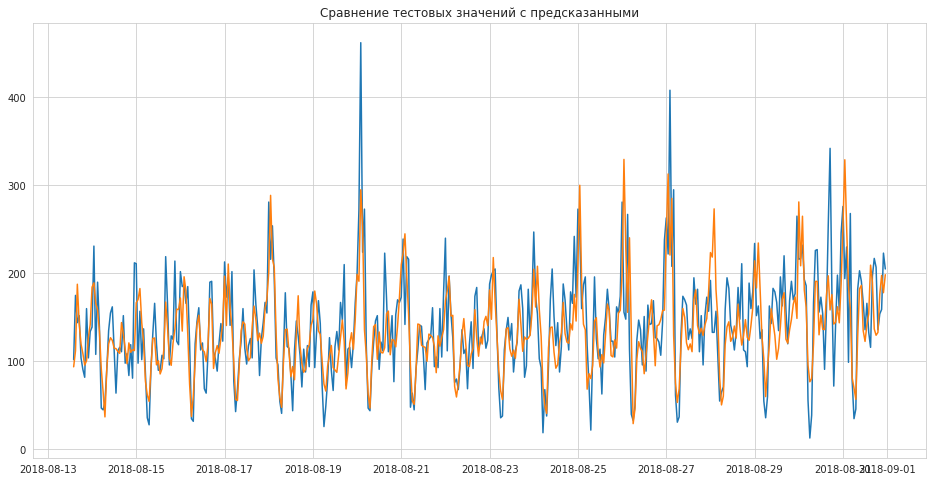

In [65]:
plt.figure(figsize=(16, 8))

plt.plot(y_test, label='target_test')
plt.plot(y_test.index, pred, label='predict_test')

plt.title('Сравнение тестовых значений с предсказанными')
plt.show()

# Общий вывод


Целью настоящего исследования ставилось создание модели, способной предсказать спрос на услуги такси с отклонением до 48 заказов в час.

Результатом тестовых испытаний стали модель, прошедшая установленный порог на тестовой выборке - gradietboosting, c показателем RMSE 42.62.

В остальном - данные так же показывают заметную сезонность- пиковые нагрузки приходятся на 00 и 16-17 часов, тогда как минимальное количество заказов поступает ранним утром (6-7 часов) и в 18 часов вечера. На основании этих данных можно рекомендовать дополнительно увеличить количество экипажей такси в часы пиковой нагрузки.
